# Computer Modeling of Epidemics with the SIR Model

In this notebook we will explore a simple numerical model of how an epidemic spreads through a population. The model is called "SIR", because every individual in the population is assigned to one of three *compartments*:
\begin{align}
S &= \textrm{Susceptible} \\
I &= \textrm{Infected} \\
R &= \textrm{Removed (or Recovered)}
\end{align}

![susceptible -> infected -> removed](images/sir_flow.png)

The code snippets in this notebook are written in the [Julia Programming Language](https://julialang.org/). You can run each cell by placing your cursor inside the cell and either clicking the "Run" button at the top of the page, or typing `Shift+Enter`. Make sure you run the code cells in order, as some of the later cells depend on the earlier ones.


## Numerical Models

Before we begin modelling the epidemic, let's look at a simpler numerical model for the motion of an object that is accelerating. The system has a number of properties of interest:

- $t$, the time (in seconds) since the start of the model
- $x$, the distance (in metres) of the object from its starting point
- $v$, the object's velocity
- $a$, the object's acceleration

These properties are related by the following system of equations:

\begin{align}
v &= \frac{dx}{dt} & \text{velocity is equal to the rate of change of distance with respect to time}\\
a &= \frac{dv}{dt} & \text{acceleration is equal to the rate of change of velocity with respect to time}\\
\text{or equivalently, }
a &= \frac{d^2x}{dt^2}
\end{align}

Given the four properties $[t,x,v,a]$, we can work out what the system will look like at some later time $(t+dt)$ by updating each property according to these equations.

The following function updates distance and velocity according to the above equations, given an acceleration and the "timestep" $dt$. Note that the update uses a midpoint formula based on half of the "old" velocity (the velocity at the beginning of the timestep) and half of the "new" velocity (the velocity at the end of the timestep).

In [3]:
function update(distance, velocity, acceleration, dt)
    new_v = velocity + acceleration * dt
    new_d = distance + 0.5(velocity * dt) + 0.5(new_v * dt)
    return new_d, new_v
end

update (generic function with 1 method)

We can use this update function to simulate the motion in the $x$ direction of an object that accelerates from a standing start at 1 metre per second per second, for example, a shopping trolley rolling downhill along a street where the distance along the street is $x$.

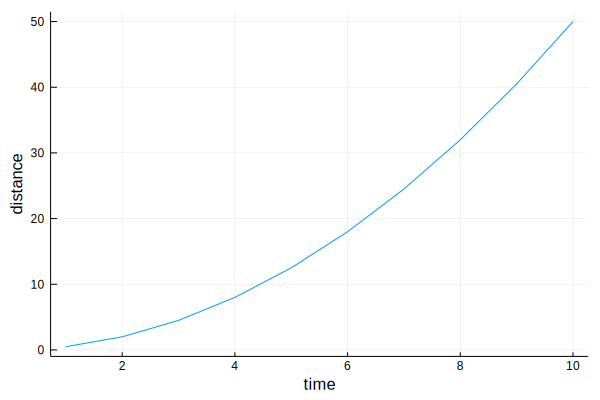

In [53]:
dt = 1.0 # time step is one second
nsteps = 10 # total time ten seconds

### TRY CHANGING THESE VALUES! ###
x = 0.0 # starting position (a distance of 0)
v = 0.0 # starting velocity (0 means object is stationary at time t=0)
a = 1.0 # accelerating at 1m/s^2

distance = Array{Float64}(undef, nsteps) # how far has the object travelled at each timestep?
for t = 1:nsteps
    x, v = update(x, v, a, dt)
    distance[t] = x
end

using Plots
plot(distance[1:nsteps], xlabel="time", ylabel="distance", legend=false)

## Computing the SIR Model

Back to the SIR model: with each timestep $dt$, the proportion of individuals in each compartment of the population changes as the epidemic spreads, according to a system of differential equations:

\begin{align}
\frac{dS}{dt} &= -\beta S(t) I(t) & \text{rate of change in } S \\
\frac{dI}{dt} &= \beta S(t) I(t) - \gamma I(t)  & \text{rate of change in } I \\
\frac{dR}{dt} &= \gamma I(t) & \text{rate of change in } R
\end{align}

The model parameters $\beta$ (beta) and $\gamma$ (gamma) represent the infection rate and the recovery rate, respectively. Note that $\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$.

![susceptible -> infected -> removed](images/sir_flow.png)

We can model the change in each compartment over time numerically by moving forward by time steps and updating each compartment based on the corresponding differential equation.

Here is update function to calculate the new proportion of individuals in each of the compartments $[S,I,R]$ after a timestep $dt$:

In [7]:
function update_SIR(s, i, r, beta, gam, dt)
    new_s = s - (beta * s * i * dt)
    new_i = i + (beta * s * i * dt) - (gam * i * dt)
    new_r = r + (gam * i * dt)
    return [new_s, new_i, new_r]
end

update_SIR (generic function with 2 methods)

We can use this function to model the change in each group over time for an imaginary outbreak in a group of 100 people over a period of six months. Initially only one person is infected. Try changing the initial numbers in each compartment, as well as the model parameters beta and gamma, and see how it changes the spread over time.

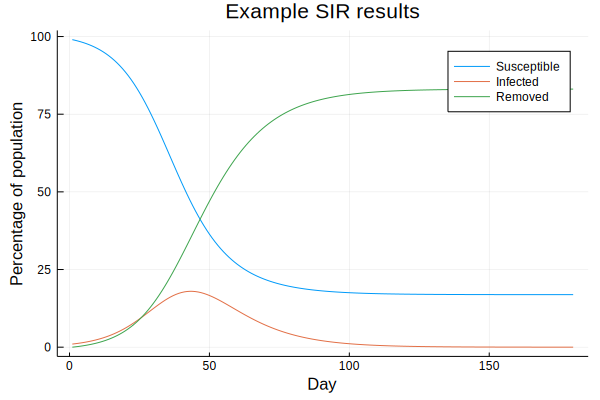

In [72]:
num_days = 180
dt = 1.0 # timestep of one day
n_steps = round(Int64, num_days / dt)
result = Array{Float64}(undef, n_steps, 3)

### TRY CHANGING THESE VALUES! ###
s = 99 # susceptible
i =  1 # infectious
r =  0 # removed
beta = 0.0021 # probability of a infection
gam = 0.1 # 1/recovery time e.g. average 10 days to recover

time = 1:n_steps
for step = time
    result[step,:] = [s, i, r]
    s, i, r = update_SIR(s, i, r, beta, gam, dt)
end

using Plots
gr()
plot(time*dt, result[1:n_steps,:], title="Example SIR results", xlabel="Day", ylabel="Percentage of population", labels = ["Susceptible" "Infected" "Removed"])

## Validating Predictions Against Real-World Data

We can also look at real world data and see how well the actual progression of COVID-19 is simulated by our SIR model. The file [au_covid.csv](au_covid.csv) contains data for the first 230 days of the COVID-19 outbreak in Australia, taken from the first 230 days of the [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19/).

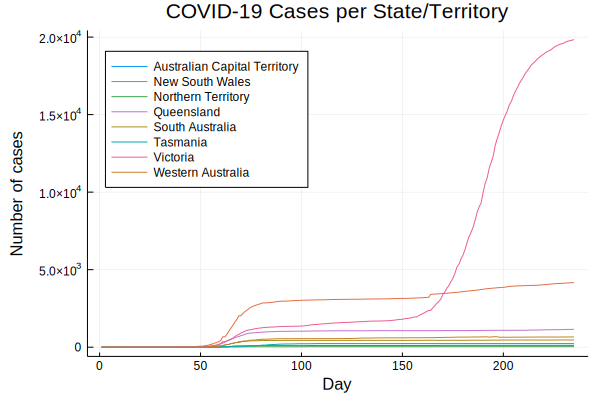

In [27]:
using CSV
x = CSV.read("au_covid.csv", transpose=true)
states = convert(Matrix, x)
state_names = reshape(String.(names(x)), 1, :)
plot(states, title="COVID-19 Cases per State/Territory", xlabel="Day", ylabel="Number of cases", labels=state_names, legend=:topleft)

We'll just look at the national total, as the numbers for most states are too small to accurately model.

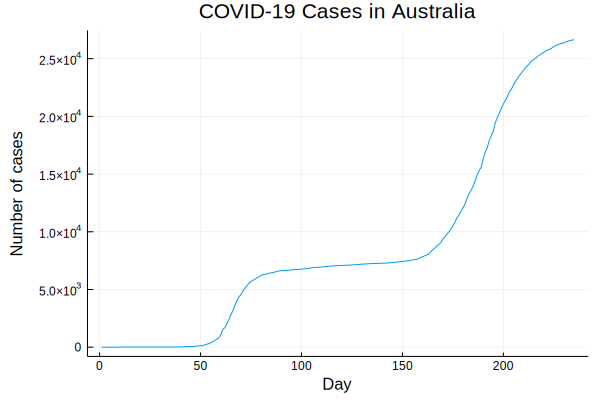

In [28]:
national=sum(states,dims=2)
plot(national,title="COVID-19 Cases in Australia", xlabel="Day", ylabel="Number of cases", legend=false)

For a population of the size of Australia, we can choose arbitrary values of beta and gamma to see how closely the SIR model matches the observed data. Try changing the values in the code below to see how it affects the fit.

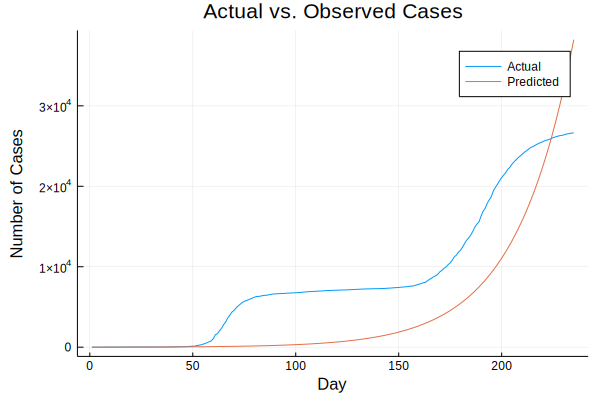

In [75]:
popsize=24600000 # population of Australia
num_days = size(states,1)
dt = 1.0 # timestep of one day
n_steps = round(Int64, num_days / dt)
result = Array{Float64}(undef, n_steps, 3)

### TRY CHANGING THESE VALUES! ###
infected = 4
beta = 3.5e-9
gam = 0.05 # 20-day infectious period

s = popsize-infected
i = infected
r = 0
time = 1:n_steps
for step = time
    result[step,:] = [s,i,r]
    s, i, r = update_SIR(result[step,:], beta, gam, dt)
end
predicted=result[time,2]+result[time,3]

plot(time*dt, [national[time],predicted], title="Actual vs. Observed Cases", xlabel="Day", ylabel="Number of Cases", labels = ["Actual" "Predicted"])

Rather than guessing the values of $\beta$ and $\gamma$, it would be better to fit them to the data to minimize the mean squared error between the predicted and actual values for each day. The [DifferentialEquations.jl](https://docs.sciml.ai/v1.6/analysis/parameter_estimation.html) package allows us to perform this fitting in Julia - but that's a subject for a future notebook.